<a href="https://colab.research.google.com/github/RG2806/ai_spotle/blob/master/new_data_4_Class_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold
from sklearn import model_selection, preprocessing, metrics, svm, ensemble
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.model_selection import GridSearchCV
import re
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
import pandas as pd
import numpy as np

# text preprocessing
from nltk.tokenize import word_tokenize
import re

# plots and metrics
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# preparing input to our model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

# keras layers
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
pd.set_option('display.max_colwidth', -1)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


In [2]:
!git clone https://github.com/RG2806/ai_spotle.git

Cloning into 'ai_spotle'...
remote: Enumerating objects: 67, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 4133 (delta 42), reused 36 (delta 30), pack-reused 4066
Receiving objects: 100% (4133/4133), 60.33 MiB | 19.11 MiB/s, done.
Resolving deltas: 100% (63/63), done.
Checking out files: 100% (4091/4091), done.


In [3]:
import pandas as pd

import os
##combine all files in the lis
#df=pd.read_json("/content/ai_spotle/aithon2020_level_3/aithon_level_3_2020-09-22T05_11_55.txt")
df = pd.concat([pd.read_json("/content/ai_spotle/aithon2020_level_3/"+f) for c,f in enumerate(os.listdir("/content/ai_spotle/aithon2020_level_3/")) ])

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 496448 entries, 0 to 17660
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   text      496448 non-null  object
 1   location  496448 non-null  object
 2   date      496448 non-null  object
 3   time      496448 non-null  object
dtypes: object(4)
memory usage: 18.9+ MB


In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

def return_missing_values(data_frame):
    missing_values = data_frame['new'].isnull().sum()/len(data_frame)
    missing_values = missing_values[missing_values>0]
    #missing_values.sort_values(inplace=True)
    return missing_values

def plot_missing_values(data_frame):
    missing_values = return_missing_values(data_frame)
    missing_values = missing_values.to_frame()
    missing_values.columns = ['count']
    missing_values.index.names = ['Name']
    missing_values['Name'] = missing_values.index
    sns.set(style='whitegrid', color_codes=True)
    sns.barplot(x='Name', y='count', data=missing_values)
    plt.xticks(rotation=90)
    plt.show()

In [42]:
return_missing_values(df)

array([], dtype=float64)

In [7]:
def return_unique_values(data_frame):
    unique_dataframe = pd.DataFrame()
    unique_dataframe['Features'] = data_frame.columns
    uniques = []
    for col in data_frame.columns:
        u = data_frame[col].nunique()
        uniques.append(u)
    unique_dataframe['Uniques'] = uniques
    return unique_dataframe

In [27]:
df['new']=df['location'].apply(lambda x: x.split(",")[-1].split(" ")[-1])

In [38]:
df['new'].value_counts().index[:20]

Index(['', 'India', 'Switzerland', 'England', 'USA', 'Kingdom', 'UK', 'CA',
       'States', 'Canada', 'Delhi', 'Pakistan', 'London', 'Netherlands',
       'VadaChennai', 'FL', 'Australia', 'Nigeria', 'Zealand', 'Kenya'],
      dtype='object')

In [37]:
udf = return_unique_values(df)
print(udf)

   Features  Uniques
0  text      13682  
1  location  3440   
2  date      10     
3  time      12442  
4  new       1624   


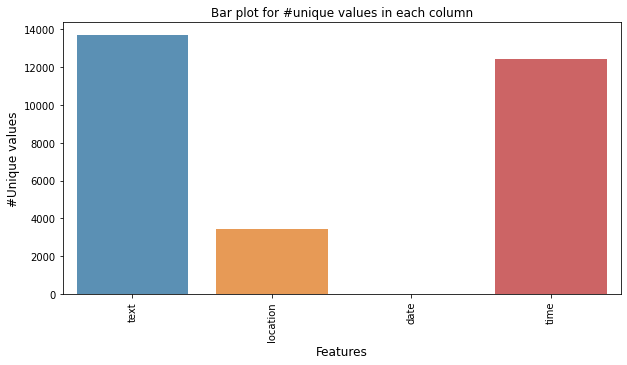

In [9]:
f, ax = plt.subplots(1,1, figsize=(10,5))#plt.figure(figsize=(10, 5))

sns.barplot(x=udf['Features'], y=udf['Uniques'], alpha=0.8)
plt.title('Bar plot for #unique values in each column')
plt.ylabel('#Unique values', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.xticks(rotation=90)
plt.show()

In [10]:
def plot_frequency_charts(df, feature, title, pallete):
    freq_df = pd.DataFrame()
    freq_df[feature] = df[feature]
    
    f, ax = plt.subplots(1,1, figsize=(16,4))
    total = float(len(df))
    g = sns.countplot(df[feature], order = df[feature].value_counts().index[:20], palette=pallete)
    g.set_title("Number and percentage of {}".format(title))

    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height/total),
                ha="center") 

    plt.title('Frequency of {} tweeting about Corona'.format(feature))
    plt.ylabel('Frequency', fontsize=12)
    plt.xlabel(title, fontsize=12)
    plt.xticks(rotation=90)
    plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


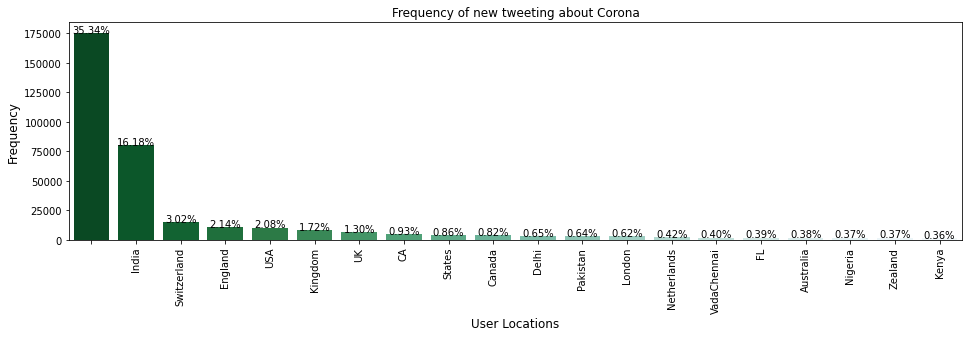

In [30]:
plot_frequency_charts(df, 'new', 'User Locations', 'BuGn_r')

In [12]:
from string import punctuation
from nltk.corpus import stopwords
print(stopwords.words('english')[10:15])

def punctuation_stopwords_removal(sms):
    # filters charecter-by-charecter : ['h', 'e', 'e', 'l', 'o', 'o', ' ', 'm', 'y', ' ', 'n', 'a', 'm', 'e', ' ', 'i', 's', ' ', 'p', 'u', 'r', 'v', 'a']
    remove_punctuation = [ch for ch in sms if ch not in punctuation]
    # convert them back to sentences and split into words
    remove_punctuation = "".join(remove_punctuation).split()
    filtered_sms = [word.lower() for word in remove_punctuation if word.lower() not in stopwords.words('english')]
    return filtered_sms

["you've", "you'll", "you'd", 'your', 'yours']


In [13]:
from collections import Counter

def draw_bar_graph_for_text_visualization(df, location):
    tweets_from_loc = df.loc[df.location==location]
    tweets_from_loc.loc[:, 'text'] = tweets_from_loc['text'].apply(punctuation_stopwords_removal)
    loc_tweets_curated = tweets_from_loc['text'].tolist()
    loc_tweet_list = []
    for sublist in loc_tweets_curated:
        for word in sublist:
            loc_tweet_list.append(word)
    loc_tweet_count = Counter(loc_tweet_list)
    loc_top_30_words = pd.DataFrame(loc_tweet_count.most_common(50), columns=['word', 'count'])
    fig, ax = plt.subplots(figsize=(16, 6))
    sns.barplot(x='word', y='count', 
                data=loc_top_30_words, ax=ax)
    plt.title("Top 50 Prevelant Words in {}".format(location))
    plt.xticks(rotation='vertical');

In [14]:
from wordcloud import WordCloud, STOPWORDS
def draw_word_cloud(df, location, title):
    loc_df = df.loc[df.location==location]
    loc_df.loc[:, 'text'] = loc_df['text'].apply(punctuation_stopwords_removal)
    word_cloud = WordCloud(
                    background_color='white',
                    stopwords=set(STOPWORDS),
                    max_words=50,
                    max_font_size=40,
                    scale=5,
                    random_state=1).generate(str(loc_df['text']))
    fig = plt.figure(1, figsize=(10,10))
    plt.axis('off')
    fig.suptitle(title, fontsize=20)
    fig.subplots_adjust(top=2.3)
    plt.imshow(word_cloud)
    plt.show()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1783: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


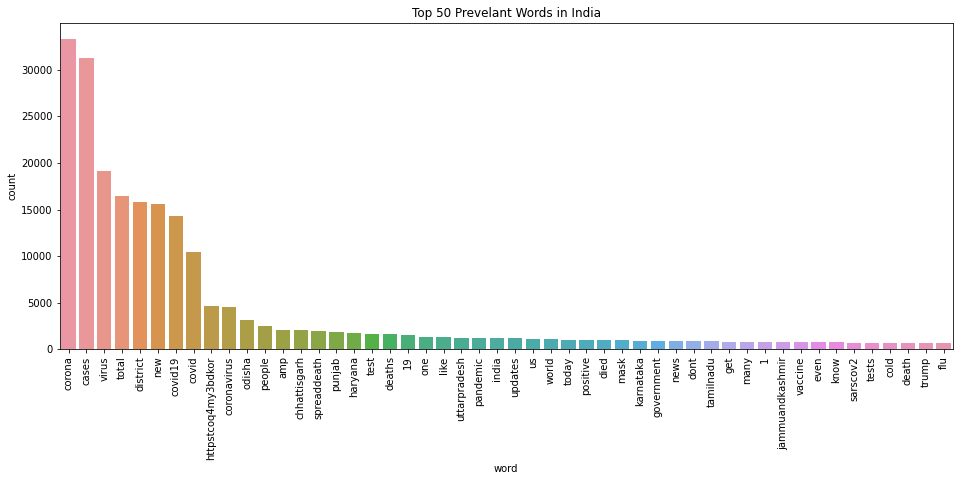

In [15]:
draw_bar_graph_for_text_visualization(df, 'India')

In [16]:
draw_word_cloud(df, 'India', 'Word Cloud for top 50 prevelant words in India')

KeyboardInterrupt: ignored

In [43]:
sentiment_df = pd.read_csv('/content/ai_spotle/finalSentimentdata2.csv')

In [44]:
sentiment_df.head()

,Unnamed: 0,sentiment,text
0,3204,sad,agree the poor in india are treated badly their poors seek a living in singapore and are treated like citizens they are given free medical treatment given food daily sim cards to call home to tell their family that they are fine if covid 19 case treated foc in hospitals
1,1431,joy,if only i could have spent the with this cutie vc sakshi__s i n g h coast crossing republik …
2,654,joy,will nature conservation remain a priority in post corona bangladesh | the daily star
3,2530,sad,"coronavirus disappearing in italy show this to ""intellectuals"" who say lockdowns do not work …"
4,2296,sad,uk records lowest daily virus death toll since start of lockdown govt


In [45]:
num_classes = 4

# Number of dimensions for word embedding
embed_num_dims = 300

# Max input length (max number of words) 
max_seq_len = 500

class_names = ['joy', 'fear', 'anger', 'sad']

In [46]:
data_train =  sentiment_df[:2472]
data_test = sentiment_df[2472:]

X_train = data_train.text
X_test = data_test.text

y_train = data_train.sentiment
y_test = data_test.sentiment

data = data_train.append(data_test, ignore_index=True)

In [47]:
def clean_text(data):
    
    # remove hashtags and @usernames
    data = re.sub(r"(#[\d\w\.]+)", '', data)
    data = re.sub(r"(@[\d\w\.]+)", '', data)
    
    # tekenization using nltk
    data = word_tokenize(data)
    
    return data

In [48]:
texts = [' '.join(clean_text(text)) for text in data.text]

texts_train = [' '.join(clean_text(text)) for text in X_train]
texts_test = [' '.join(clean_text(text)) for text in X_test]

In [49]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

sequence_train = tokenizer.texts_to_sequences(texts_train)
sequence_test = tokenizer.texts_to_sequences(texts_test)

index_of_words = tokenizer.word_index

# vacab size is number of unique words + reserved 0 index for padding
vocab_size = len(index_of_words) + 1

print('Number of unique words: {}'.format(len(index_of_words)))

Number of unique words: 10575


In [50]:
X_train_pad = pad_sequences(sequence_train, maxlen = max_seq_len )
X_test_pad = pad_sequences(sequence_test, maxlen = max_seq_len )

X_train_pad

array([[   0,    0,    0, ..., 3111,    6,  409],
       [   0,    0,    0, ..., 4546, 4547,   30],
       [   0,    0,    0, ...,    1,  280,  839],
       ...,
       [   0,    0,    0, ...,  223, 2338,  238],
       [   0,    0,    0, ...,   34,   35, 9354],
       [   0,    0,    0, ..., 2318,  659,  178]], dtype=int32)

In [51]:
encoding = {
    'joy': 0,
    'fear': 1,
    'anger': 2,
    'sad': 3,
}

# Integer labels
y_train = [encoding[x] for x in data_train.sentiment]
y_test = [encoding[x] for x in data_test.sentiment]

In [52]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

y_train

array([[0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.]], dtype=float32)

In [53]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix

In [54]:
import urllib.request
import zipfile
import os

fname = 'embeddings/wiki-news-300d-1M.vec'

if not os.path.isfile(fname):
    print('Downloading word vectors...')
    urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip',
                              'wiki-news-300d-1M.vec.zip')
    print('Unzipping...')
    with zipfile.ZipFile('wiki-news-300d-1M.vec.zip', 'r') as zip_ref:
        zip_ref.extractall('embeddings')
    print('done.')
    
    os.remove('wiki-news-300d-1M.vec.zip')

Unzipping...
done.


In [55]:
embedd_matrix = create_embedding_matrix('/content/embeddings/wiki-news-300d-1M.vec', index_of_words, embed_num_dims)
embedd_matrix.shape

(10576, 300)

In [56]:
new_words = 0

for word in index_of_words:
    entry = embedd_matrix[index_of_words[word]]
    if all(v == 0 for v in entry):
        new_words = new_words + 1

print('Words found in wiki vocab: ' + str(len(index_of_words) - new_words))
print('New words found: ' + str(new_words))

Words found in wiki vocab: 8945
New words found: 1630


In [57]:
embedd_layer = Embedding(vocab_size,
                         embed_num_dims,
                         input_length = max_seq_len,
                         weights = [embedd_matrix],
                         trainable=False)

In [58]:
# Convolution
kernel_size = 3
filters = 256

model = Sequential()
model.add(embedd_layer)
model.add(Conv1D(filters, kernel_size, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(256, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

In [59]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 300)          3172800   
_________________________________________________________________
conv1d (Conv1D)              (None, 498, 256)          230656    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1028      
Total params: 3,470,276
Trainable params: 297,476
Non-trainable params: 3,172,800
_________________________________________________________________


In [60]:
batch_size = 256
epochs = 50

hist = model.fit(X_train_pad, y_train, 
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=(X_test_pad,y_test))

Epoch 1/50
10/10 [==============================] - 1s 100ms/step - loss: 1.3260 - accuracy: 0.3612 - val_loss: 1.1975 - val_accuracy: 0.5016
Epoch 2/50
10/10 [==============================] - 1s 73ms/step - loss: 1.0792 - accuracy: 0.5667 - val_loss: 1.0766 - val_accuracy: 0.4887
Epoch 3/50
10/10 [==============================] - 1s 73ms/step - loss: 0.9277 - accuracy: 0.6234 - val_loss: 0.9888 - val_accuracy: 0.5550
Epoch 4/50
10/10 [==============================] - 1s 72ms/step - loss: 0.7629 - accuracy: 0.7407 - val_loss: 0.8926 - val_accuracy: 0.6165
Epoch 5/50
10/10 [==============================] - 1s 72ms/step - loss: 0.6108 - accuracy: 0.8135 - val_loss: 0.8063 - val_accuracy: 0.6683
Epoch 6/50
10/10 [==============================] - 1s 72ms/step - loss: 0.4610 - accuracy: 0.8673 - val_loss: 0.7334 - val_accuracy: 0.7104
Epoch 7/50
10/10 [==============================] - 1s 72ms/step - loss: 0.3458 - accuracy: 0.9167 - val_loss: 0.6835 - val_accuracy: 0.7379
Epoch 8/50
1

In [61]:
import time

message = ['delivery was hour late and my pizza was cold!']

seq = tokenizer.texts_to_sequences(message)
padded = pad_sequences(seq, maxlen=max_seq_len)

start_time = time.time()
pred = model.predict(padded)

print('Message: ' + str(message))
print('predicted: {} ({:.2f} seconds)'.format(class_names[np.argmax(pred)], (time.time() - start_time)))

Message: ['delivery was hour late and my pizza was cold!']
predicted: sad (0.10 seconds)


In [62]:
import pandas as pd

import os
##combine all files in the lis
#df=pd.read_json("/content/ai_spotle/aithon2020_level_3/aithon_level_3_2020-09-22T05_11_55.txt")
df = pd.concat([pd.read_json("/content/ai_spotle/aithon2020_level_3/"+f) for c,f in enumerate(os.listdir("/content/ai_spotle/aithon2020_level_3/")) ])

In [63]:
tok = WordPunctTokenizer()
lemma = WordNetLemmatizer()
# patterns to remove html tags numbers and special Characters
pat1 = r'@[A-Za-z0-9_]+'
pat2 = r'https?://[^ ]+'
op = r'\bcovid\b\s+'
combined_pat = r'|'.join((pat1, pat2))
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
shortcuts = {'u': 'you', 'y': 'why', 'r': 'are', 'doin': 'doing', 'hw': 'how', 'k': 'okay', 'm': 'am', 'b4': 'before',
            'idc': "i do not care", 'ty': 'thankyou', 'wlcm': 'welcome', 'bc': 'because', '<3': 'love', 'xoxo': 'love',
            'ttyl': 'talk to you later', 'gr8': 'great', 'bday': 'birthday', 'awsm': 'awesome', 'gud': 'good', 'h8': 'hate',
            'lv': 'love', 'dm': 'direct message', 'rt': 'retweet', 'wtf': 'hate', 'idgaf': 'hate',
             'irl': 'in real life', 'yolo': 'you only live once'}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')
shortcuts_pattern = re.compile(r'\b(' + '|'.join(shortcuts.keys()) + r')\b')
def clean_text(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        bom_removed = souped
    stripped = re.sub(combined_pat, '', bom_removed)#for removing patterns like #,@ and punctuation
    lower_case = stripped.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    shortcuts_handled = shortcuts_pattern.sub(lambda x: shortcuts[x.group()],neg_handled)
    letters_only = re.sub("[^a-zA-Z]", " ", shortcuts_handled)
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]
    lemmated_words = [lemma.lemmatize(word) for word in words]
    return (" ".join( lemmated_words)).strip()

In [64]:
df=df.drop_duplicates('text')
#df=df[df['location'].apply(lambda x: x.lower().find("india")>-1)]
df['cleaned_tweets'] = df['text'].apply(lambda x: clean_text(x))

In [65]:
print(df.shape)
df.head()

(13682, 5)


,text,location,date,time,cleaned_tweets
0,"COVID-19 claims 6 more lives, infects 194 others: CM Sindh \n\n#APPNews @MuradAliShahPPP #coronavirus #Corona #CoronavirusPandemic \n\nhttps://t.co/M9brEO1Ghh via appcsocialmedia",IN,Sep 22,14:28:17,covid claim more life infects others cm sindh appnews coronavirus corona coronaviruspandemic via appcsocialmedia
1,"@AlyssaCoachala @thehill ""deliberately embellished Corona virus""🤣\n\nTRUMP: \n\n""You just breathe the air and that’s how it’s passed.” \n“COVID is much more deadly than even your strenuous flu.” “This is deadly stuff”\n\n“5% death rate”","Islamabad, Pakistan",Sep 22,14:28:01,deliberately embellished corona virus trump you just breathe the air and that how it passed covid is much more deadly than even your strenuous flu this is deadly stuff death rate
2,Covid-19 era diplomacy. Having Barents Euro-Arctic Council Senior Officials meeting in virtual format. Determined to further develop our cooperation despite the currents restrictions. Good discussion on future priorities on climate change beyond corona. ⁦@barents_beac⁩ https://t.co/ulJkUIDnPE,The NYC,Sep 22,14:27:32,covid era diplomacy having barents euro arctic council senior official meeting in virtual format determined to further develop our cooperation despite the current restriction good discussion on future priority on climate change beyond corona
3,@WINDOCTORRX Operation Corona was about hysteria and fear to falsely justify mail-in voting to fraud the election. That's why all deaths were listed as 'covid' with medical industry awarded a bounty for each death. https://t.co/1UyDI8OcIK,"Helsinki, Finland",Sep 22,14:26:45,operation corona wa about hysteria and fear to falsely justify mail in voting to fraud the election that why all death were listed a covid with medical industry awarded bounty for each death
4,"The neighborhood kids can be so funny!\nA stray dog has delivered 3 puppies.\nThe kids have named the mother Corona.......and the puppies are called Covid, Virus and Flu!! 🙆‍♀️🤦‍♀️\n#Humourinlife",Erie Michigan,Sep 22,14:24:48,the neighborhood kid can be so funny stray dog ha delivered puppy the kid have named the mother corona and the puppy are called covid virus and flu humourinlife


In [66]:
def check(s):
  message = [s]
  seq = tokenizer.texts_to_sequences(message)
  padded = pad_sequences(seq, maxlen=max_seq_len)
  pred = model.predict(padded)
  return class_names[np.argmax(pred)]
df['analysis'] = df['cleaned_tweets'].apply(lambda x : check(x))

In [67]:
df.groupby('analysis').count()

,text,location,date,time,cleaned_tweets
analysis,,,,,
anger,1626,1626,1626,1626,1626
fear,4007,4007,4007,4007,4007
joy,2758,2758,2758,2758,2758
sad,5291,5291,5291,5291,5291


,text,location,date,time,cleaned_tweets,analysis
0,"COVID-19 claims 6 more lives, infects 194 others: CM Sindh \n\n#APPNews @MuradAliShahPPP #coronavirus #Corona #CoronavirusPandemic \n\nhttps://t.co/M9brEO1Ghh via appcsocialmedia",IN,Sep 22,14:28:17,covid claim more life infects others cm sindh appnews coronavirus corona coronaviruspandemic via appcsocialmedia,sad
5,"September 22nd,2020 corona update, Nepal\n2 New deaths, \n823 Recovered, \n1356 new cases of COVID-19 Confirmed\nTotal Cases: 66632, \nActive Cases: 18571, \nTotal Deaths: 429,\nPCR tests on 22nd September: 11154\nTotal PCR tests: 934977",,Sep 22,14:23:58,september nd corona update nepal new death recovered new case of covid confirmed total case active case total death pcr test on nd september total pcr test,sad
10,Does art still hold a place during times when people are more focused on their struggle to survive the COVID-19 pandemic? #digitalmarketingagency https://t.co/MPbzG0bfGY https://t.co/x1OQN48mJM,,Sep 22,14:22:41,doe art still hold place during time when people are more focused on their struggle to survive the covid pandemic digitalmarketingagency,sad
11,"September 21st,2020 corona update, Nepal\n16 New deaths, \n1005 Recovered, \n1154 new cases of COVID-19 Confirmed\nTotal Cases: 65276, \nActive Cases: 18038, \nTotal Deaths: 427,\nPCR tests on 21st September: 9533\nTotal PCR tests: 923823",London,Sep 22,14:22:34,september st corona update nepal new death recovered new case of covid confirmed total case active case total death pcr test on st september total pcr test,sad
12,"Scaling up the state’s fight against #COVID, Chief Minister @capt_amarinder Singh launched the Corona Fateh Kits, which the state government will start distributing immediately to all #COVID patients in isolation, whether at home or in hospitals.\nhttps://t.co/t22nKsfPgA",Nepal,Sep 22,14:22:32,scaling up the state fight against covid chief minister singh launched the corona fateh kit which the state government will start distributing immediately to all covid patient in isolation whether at home or in hospital,sad
13,"Covid news\n\nBangladesh has become the 29th nation to lose 5000 people to the virus.\n\n100 countries have now reported over 9000 cases of Corona. \nPoland is the 44th nation with over 80,000 cases and Indonesia is the 23rd nation to report a quarter of a million cases. https://t.co/oqGySpaZb6","Fatehgarh Sahib , Punjab",Sep 22,14:22:28,covid news bangladesh ha become the th nation to lose people to the virus country have now reported over case of corona poland is the th nation with over case and indonesia is the rd nation to report quarter of million case,sad
16,"Scaling up the state’s fight against #COVID, Chief Minister @capt_amarinder Singh launched the Corona Fateh Kits, which the state government will start distributing immediately to all #COVID patients in isolation, whether at home or in hospitals.\nhttps://t.co/6eImJKTtpH",Switzerland,Sep 22,14:21:39,scaling up the state fight against covid chief minister singh launched the corona fateh kit which the state government will start distributing immediately to all covid patient in isolation whether at home or in hospital,sad
17,"Scaling up the state’s fight against #COVID, Chief Minister @capt_amarinder Singh launched the Corona Fateh Kits, which the state government will start distributing immediately to all #COVID patients in isolation, whether at home or in hospitals.\nhttps://t.co/6V7SRzhMe4","Patiala, Punjab",Sep 22,14:21:15,scaling up the state fight against covid chief minister singh launched the corona fateh kit which the state government will start distributing immediately to all covid patient in isolation whether at home or in hospital,sad
21,"Scaling up the state’s fight against #COVID, Chief Minister @capt_amarinder Singh launched the Corona Fateh Kits, which the state government will start distributing immediately to all #COVID patients in isolation, whether at home or in hospitals.\nhttps://t.co/Dxxwycj

In [ ]:
You can access specific tweets by their id with the statuses/show/:id API route. Most Python Twitter libraries follow the exact same patterns, or offer 'friendly' names for the methods.

For example, Twython offers several show_* methods, including Twython.show_status() that lets you load specific tweets:

CONSUMER_KEY = "<consumer key>"
CONSUMER_SECRET = "<consumer secret>"
OAUTH_TOKEN = "<application key>"
OAUTH_TOKEN_SECRET = "<application secret"
twitter = Twython(
    CONSUMER_KEY, CONSUMER_SECRET,
    OAUTH_TOKEN, OAUTH_TOKEN_SECRET)

tweet = twitter.show_status(id=id_of_tweet)
print(tweet['text'])